In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD

In [2]:
USE_TENSORFLOW_AS_BACKEND = True

In [3]:
%matplotlib inline
from scipy import misc
import seaborn

In [4]:
if USE_TENSORFLOW_AS_BACKEND:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
else:
    os.environ['KERAS_BACKEND'] = 'theano'

In [5]:
import keras
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV3Small
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.utils import np_utils

**Dataset**

In [ ]:
# ![[ -f 101_ObjectCategories ]] || tar -xvzf 101_ObjectCategories.tar.gz

In [7]:
# !unzip 101_ObjectCategories.zip -d /content


Streaming output truncated to the last 5000 lines.
  inflating: /content/101_ObjectCategories/Faces_easy/image_0241.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0242.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0243.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0244.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0245.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0246.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0247.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0248.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0249.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0250.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0251.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0252.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0253.jpg  
  inflating: /content/101_

In [6]:
!ls 101_ObjectCategories

ls: cannot access '101_ObjectCategories': No such file or directory


In [8]:
# !pip install scipy==1.2.2

     |████████████████████████████████| 24.8 MB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


**Data preprocessing**

In [6]:
# functions to load the data
# def load_batch_images(path, n_examples_train, n_examples_validation=2, max_imgs_by_class=30, nb_categories=4, resize_to_size=(224,224)):

def load_batch_images(path, n_examples_train, n_examples_validation=2, max_imgs_by_class=30, nb_categories=4, resize_to_size=(224,224)):

    images_train = []
    labels_train = []
    images_validation = []
    labels_validation = []
    
    # Get categories from path
    categories_list = os.listdir(path)
    categories_list = [category for category in categories_list if category != '.DS_Store']
    if isinstance(nb_categories, int) and len(categories_list) >= nb_categories:
        categories_list = categories_list[0:nb_categories]

    # For each category...
    for idx, category in enumerate(categories_list):
        # ... get images in category ...
        images_list = os.listdir(os.path.join(path, category))        
        if len(images_list) > max_imgs_by_class:
            images_list = images_list[:max_imgs_by_class]
        
        indx = 0
        for images in images_list[:n_examples_train + n_examples_validation]:                
            # ... load them ...
            img = load_img(os.path.join(path, category, images))  # as PIL images
            img = img_to_array(img)                               # as numpy array
            img = misc.imresize(img, resize_to_size)              # resize
            # img = misc.imrotate(img, 180)
            if indx < n_examples_train:
                images_train.append(img)
                labels_train.append(idx)
            else:
                images_validation.append(img)
                labels_validation.append(idx)
            indx += 1
    
    # Convert to one-hot
    labels_train = np_utils.to_categorical(labels_train)
    labels_validation = np_utils.to_categorical(labels_validation)

    return images_train, labels_train, images_validation, labels_validation


In [7]:
def shuffle_dataset(a, b):
    """Shuffle the entire dataset"""
    assert np.shape(a)[0] == np.shape(b)[0]
    p = np.random.permutation(np.shape(a)[0])
    return (a[p], b[p])

In [8]:
def get_data(samples_by_category=8, dataset_path="./101_ObjectCategories/", nb_categories=4):
    images_train, labels_train, images_validation, labels_validation = load_batch_images(path=dataset_path, n_examples_train=samples_by_category, n_examples_validation=20, max_imgs_by_class=30, nb_categories=nb_categories)

    images_train = np.float64(images_train)
    images_validation = np.float64(images_validation)

    images_train = preprocess_input(images_train)  # substract the mean RGB channels of the imagenet dataset. This is because the Inception model we are using has been trained on a different dataset (imagenet dataset)
    images_validation = preprocess_input(images_validation)

    if not USE_TENSORFLOW_AS_BACKEND:
        images_validation = images_validation.swapaxes(1, 3).swapaxes(2, 3)
        images_train = images_train.swapaxes(1, 3).swapaxes(2, 3)

    train = shuffle_dataset(np.asarray(images_train), labels_train)
    validation = shuffle_dataset(np.asarray(images_validation), labels_validation)

    images_train, labels_train = train
    images_validation, labels_validation = validation

    return images_train, labels_train, train, images_validation, labels_validation, validation

In [9]:
def demo_plot():
    demo_path = "./101_ObjectCategories/"

    demo_data, _, _, _ = load_batch_images(path=demo_path, n_examples_train=8, n_examples_validation=20)
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(demo_data[0])
    axarr[1,0].imshow(demo_data[1])
    axarr[0,1].imshow(demo_data[27])
    axarr[1,1].imshow(demo_data[31])
    axarr[0,0].grid('off')
    axarr[0,1].grid('off')
    axarr[1,0].grid('off')
    axarr[1,1].grid('off')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


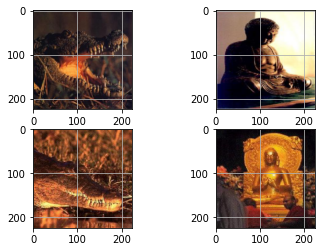

In [10]:
demo_plot()

In [52]:
nb_categories = 50  #4         # out of 101 classes
samples_by_category = 29  # out of about 50 images for each category

# Load the data!
train_img, train_labels, train, val_img, val_labels, val = get_data(samples_by_category=samples_by_category, dataset_path='./101_ObjectCategories/', nb_categories=nb_categories)

# # Normalize pixel values to be between 0 and 1
# train_img, val_img = train_img / 255.0, val_img / 255.0

# Print the tensors shapes
print('Shapes (train) :', train_img[0].shape, train_labels[0].shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Shapes (train) : (224, 224, 3) (50,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


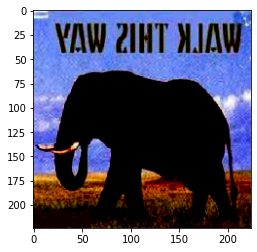

In [57]:
# get_label_name = metadata.features['label'].int2str

for i in range(len(train_img)):
  image, label = train_img[i], train_labels[i]
_ = plt.imshow(image)


In [58]:
# Add the image to a batch
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

In [59]:
# IMG_SIZE = 224

# resize_and_rescale = tf.keras.Sequential([
#   layers.Resizing(IMG_SIZE, IMG_SIZE),
#   # layers.Rescaling(1./255)                                          
# ])

In [60]:
# result = resize_and_rescale(image)
# _ = plt.imshow(result)

In [64]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),                                         
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


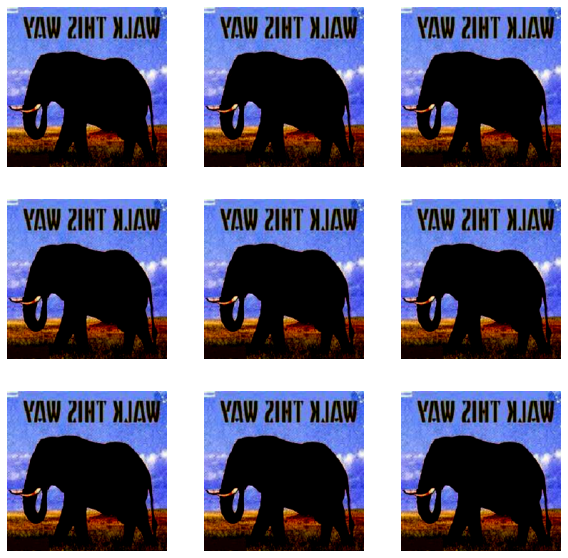

In [65]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

**Transfer learning**

InceptionV3

knowledge being reused for another similar dataset or task

https://people.minesparis.psl.eu/fabien.moutarde/ES_LSML/TP_TransferLearning-ConvNet/transfer_learning.html

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [ ]:
# print all the layers
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [ ]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(32, activation='relu')(x)

# and a logistic layer -- we have nb_categories classes
predictions = Dense(nb_categories, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False
    
# print adapted model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [ ]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
# train the model on the new data for a few epochs
history = model.fit(train_img, train_labels, batch_size=32, validation_data=(val_img, val_labels), epochs=12)

Epoch 1/12
2/2 [==============================] - 19s 3s/step - loss: 1.8466 - acc: 0.2000 - val_loss: 1.2287 - val_acc: 0.5500
Epoch 2/12
2/2 [==============================] - 0s 236ms/step - loss: 0.9840 - acc: 0.6750 - val_loss: 0.7279 - val_acc: 0.8500
Epoch 3/12
2/2 [==============================] - 0s 235ms/step - loss: 0.4876 - acc: 1.0000 - val_loss: 0.5177 - val_acc: 0.8875
Epoch 4/12
2/2 [==============================] - 0s 238ms/step - loss: 0.2912 - acc: 1.0000 - val_loss: 0.3957 - val_acc: 0.8875
Epoch 5/12
2/2 [==============================] - 0s 239ms/step - loss: 0.1705 - acc: 1.0000 - val_loss: 0.2665 - val_acc: 0.9500
Epoch 6/12
2/2 [==============================] - 0s 358ms/step - loss: 0.0746 - acc: 1.0000 - val_loss: 0.2178 - val_acc: 0.9625
Epoch 7/12
2/2 [==============================] - 0s 242ms/step - loss: 0.0394 - acc: 1.0000 - val_loss: 0.2176 - val_acc: 0.9375
Epoch 8/12
2/2 [==============================] - 0s 241ms/step - loss: 0.0242 - acc: 1.0000

In [ ]:
print(model.metrics_names)
print(model.evaluate(val_img, val_labels, verbose=0))

['loss', 'acc']
[0.18391916155815125, 0.925000011920929]


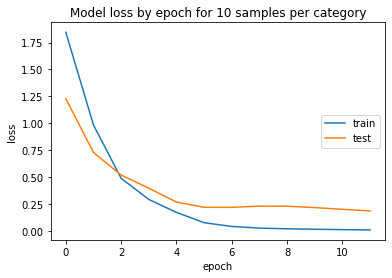

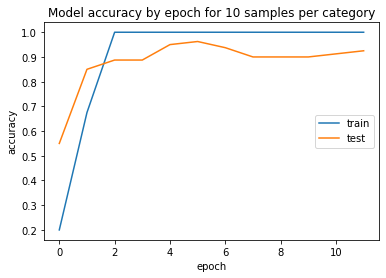

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch for %d samples per category' % samples_by_category)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy by epoch for %d samples per category' % samples_by_category)
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='right')
plt.xlabel('epoch')
plt.show()

------------------------------------

Transfer Learning (MobileNetV3)

In [ ]:
base_model = MobileNetV3Small(input_shape=(224,224,3), classes=133,
                             weights="imagenet", pooling=None, include_top=False)

In [ ]:
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                   

In [ ]:
for layer in base_model.layers:
    layer.trainable = False
last_output = base_model.layers[-1].output
x = layers.GlobalMaxPooling2D()(last_output)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(50, activation='softmax')(x)
model = Model(base_model.input, x)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])


In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                            

In [ ]:
history = model.fit(train_img, train_labels, batch_size=32, validation_data=(val_img, val_labels), epochs=12)

Epoch 1/12
46/46 [==============================] - 8s 69ms/step - loss: 3.5399 - acc: 0.1572 - val_loss: 4.7073 - val_acc: 0.0600
Epoch 2/12
46/46 [==============================] - 2s 43ms/step - loss: 2.1943 - acc: 0.4862 - val_loss: 4.0317 - val_acc: 0.1400
Epoch 3/12
46/46 [==============================] - 2s 43ms/step - loss: 1.6346 - acc: 0.6248 - val_loss: 3.4431 - val_acc: 0.2000
Epoch 4/12
46/46 [==============================] - 2s 42ms/step - loss: 1.2870 - acc: 0.7007 - val_loss: 3.0200 - val_acc: 0.2800
Epoch 5/12
46/46 [==============================] - 2s 42ms/step - loss: 1.0200 - acc: 0.7683 - val_loss: 2.6916 - val_acc: 0.3400
Epoch 6/12
46/46 [==============================] - 2s 42ms/step - loss: 0.8521 - acc: 0.8083 - val_loss: 2.3467 - val_acc: 0.3400
Epoch 7/12
46/46 [==============================] - 2s 42ms/step - loss: 0.6982 - acc: 0.8462 - val_loss: 2.3066 - val_acc: 0.3000
Epoch 8/12
46/46 [==============================] - 2s 43ms/step - loss: 0.6045 - a

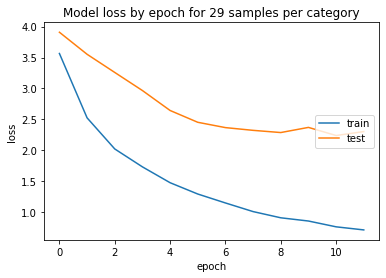

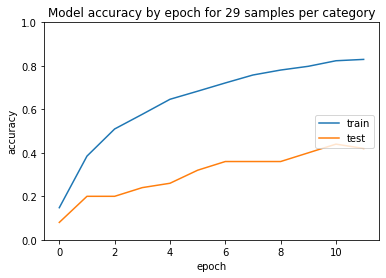

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch for %d samples per category' % samples_by_category)
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.ylim([0, 1])
plt.legend(['train', 'test'], loc='right')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy by epoch for %d samples per category' % samples_by_category)
plt.ylabel('accuracy')
plt.ylim([0, 1])
plt.legend(['train', 'test'], loc='right')
plt.xlabel('epoch')
plt.show()

---------------------------------------------------

**Training model**

https://www.tensorflow.org/tutorials/images/cnn

https://github.com/deepseasw/caltech101-image-cnn-classification/blob/master/Image%20CNN%20Classification.ipynb

In [83]:
base_model = MobileNetV3Small(input_shape=(224,224,3), classes=50,
                             weights="imagenet", pooling=None, include_top=False)

In [84]:
base_model.trainable = True

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    # layer.trainable = True

last_output = base_model.layers[-1].output
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = layers.GlobalMaxPooling2D()(last_output)
# x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# x = layers.BatchNormalization()(x)
x = layers.Dense(50, activation='softmax')(x)

# x = layers.Conv2D(16, (3,3), activation='relu')(last_output)
# x = layers.MaxPooling2D(2,2)(x)
# x = layers.Conv2D(32, (3, 3), activation='relu')(x)
# x = layers.MaxPooling2D((2, 2))(x)
# x = layers.Conv2D(64, (3, 3), activation='relu')(x)
# x = layers.MaxPooling2D((2, 2))(x)
# x = layers.Flatten()(x)
# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dense(50, activation='softmax')(x)
model = Model(base_model.input, x)

In [ ]:
train_img

In [ ]:
# res = data_augmentation(train_img)
# for im in res:
#   im = im.numpy()
#   print(im+0.5)
#   break



In [ ]:
model.summary()

In [ ]:
# inputs = tf.keras.Input(shape=(224, 224, 3)
# )
# model = tf.keras.Sequential([
#   # resize_and_rescale,
#   tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
#   # data_augmentation
# ])

# for layer in model.layers:
#     layer.trainable = False
# last_output = model.layers[-1].output
# # x = tf.keras.layers.InputLayer(input_shape=(224, 224, 3))
# x = data_augmentation(tf.keras.Input(shape=(224, 224, 3)))
# x = layers.Conv2D(16, (3,3), activation='relu')(last_output)
# x = layers.MaxPooling2D(2,2)(x)
# x = layers.Conv2D(32, (3, 3), activation='relu')(x)
# x = layers.MaxPooling2D((2, 2))(x)
# x = layers.Conv2D(64, (3, 3), activation='relu')(x)
# x = layers.MaxPooling2D((2, 2))(x)
# x = layers.Flatten()(x)
# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dense(50, activation='softmax')(x)
# final_model= Model(model_trained.input, x)

# # model.build()

In [ ]:
from keras.engine.input_layer import InputLayer
#conv로 블록을 계속 쌓으면 인풋이 뭐였는지 까먹는다
#그래서 인풋에 들어간것을 중간에 concatenate해줌 (residual, resnet)

# #input
# model = models.Sequential()
# data_augmentation
# model.add(layers.Conv2D(16, 3, padding='same', activation = 'relu'))
# model.add(layers.MaxPooling2D())

# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
# model.add(layers.BatchNormalization())
# # model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.MaxPool2D())

# #blocks
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.BatchNormalization())
# # model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.MaxPool2D())
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.BatchNormalization())
# # model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.MaxPool2D())
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.BatchNormalization())
# # model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.MaxPool2D())

# # output
# # model.add(layers.Flatten())
# model.add(layers.GlobalAvgPool2D())
# # model.add(layers.Dense(2048, activation='softmax'))
# model.add(layers.Dense(128, activation='relu'))
# # tf.keras.layers.Dropout(0.2),
# model.add(layers.Dense(50))

# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', 
#                         input_shape=(224, 224, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))   

# model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(128, activation='relu'))
# # model.add(tf.keras.layers.BatchNormalization())
# model.add(layers.Dense(50, activation='softmax'))




# model = tf.keras.Sequential([
#   # resize_and_rescale,
#   tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
#   data_augmentation,  
#   # model_trained,
#   # tf.keras.layers.InputLayer(model_trained),
#   # layers.Conv2D(16, 3, padding='same', activation = 'relu'),
#   # layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
#   layers.Conv2D(16, (3,3), activation='relu'),
#   # layers.BatchNormalization(),
#   layers.MaxPooling2D(2,2), 
#   # layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#   # layers.Conv2D(16, (3, 3), activation='relu'),
#   # # layers.BatchNormalization(),
#   # # layers.MaxPooling2D((2, 2)),
#   layers.Conv2D(32, (3, 3), activation='relu'),
#   layers.MaxPooling2D((2, 2)),
#   # layers.Conv2D(32, (3, 3), activation='relu'),
#   # layers.MaxPooling2D((2, 2)),
#   layers.Conv2D(64, (3, 3), activation='relu'),
#   layers.MaxPooling2D((2, 2)),
#   # layers.Conv2D(64, (3, 3), activation='relu'),
#   # layers.MaxPooling2D((2, 2)),
#   # layers.Conv2D(128, (3, 3), activation='relu'),
#   # layers.MaxPooling2D((2, 2)),
#   # layers.Conv2D(128, (3, 3), activation='relu'),
#   # layers.MaxPooling2D((2, 2)),
#   # layers.Conv2D(128, (3, 3), activation='relu'),
#   # layers.MaxPooling2D((2, 2)),

#   layers.Flatten(),
#   # layers.Dropout(0.5),
#   layers.Dense(128, activation='relu'),
#   # layers.BatchNormalization(),
#   layers.Dense(50, activation='softmax')                             
# ])





In [ ]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

In [77]:
# # output
# # model.add(layers.Flatten())
# model.add(layers.GlobalAvgPool2D())
# # model.add(layers.Dense(2048, activation='softmax'))
# model.add(layers.Dense(128, activation='relu'))
# # tf.keras.layers.Dropout(0.2),
# model.add(layers.Dense(20))

In [78]:
# model.summary()

In [85]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.sparse_categorical_crossentropy(from_logits=True),
#               metrics=['acc'])
# model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy(from_logits=True), metrics=['acc'])
# from keras.optimizers import SGD

# opt = SGD(lr=0.01)
# model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ['acc'])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# optimizer=sgd (지금은 안 쓰여짐)
# train the model on the new data for a few epochs
history = model.fit(train_img, train_labels,batch_size=2, validation_data=(val_img, val_labels), epochs=50)

Epoch 1/50
725/725 [==============================] - 21s 16ms/step - loss: 4.3809 - acc: 0.0469 - val_loss: 3.9602 - val_acc: 0.0200
Epoch 2/50
725/725 [==============================] - 11s 14ms/step - loss: 3.3728 - acc: 0.1628 - val_loss: 4.0765 - val_acc: 0.1600
Epoch 3/50
725/725 [==============================] - 11s 15ms/step - loss: 2.6576 - acc: 0.3041 - val_loss: 4.1427 - val_acc: 0.1800
Epoch 4/50
725/725 [==============================] - 11s 15ms/step - loss: 2.0716 - acc: 0.4166 - val_loss: 3.0794 - val_acc: 0.3200
Epoch 5/50
725/725 [==============================] - 11s 15ms/step - loss: 1.5755 - acc: 0.5434 - val_loss: 3.9684 - val_acc: 0.1400
Epoch 6/50
725/725 [==============================] - 10s 14ms/step - loss: 1.2084 - acc: 0.6386 - val_loss: 5.0670 - val_acc: 0.2000
Epoch 7/50
725/725 [==============================] - 11s 15ms/step - loss: 0.9741 - acc: 0.7131 - val_loss: 4.7091 - val_acc: 0.2200
Epoch 8/50
725/725 [==============================] - 10s 14ms

2/2 - 1s - loss: 1.8200 - acc: 0.6200 - 868ms/epoch - 434ms/step


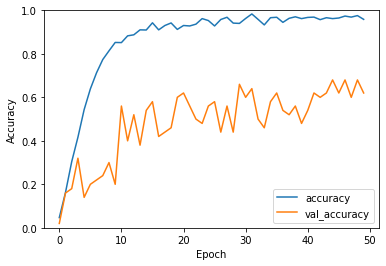

In [86]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_img,  val_labels, verbose=2)

In [ ]:
print(test_acc)

----------------------------------------
---------------------------------------

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_img[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    # plt.xlabel([train_labels[i][0]])
plt.show()

In [ ]:
# for showing separarate images
image = train_img[39]
plt.imshow(image)
plt.show()